- Handling warnings

In [364]:
import warnings
warnings.filterwarnings("ignore")

- Loading modules

In [365]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.rc('font', size=12)

- Auxiliar functions

In [366]:
def get_metrics(y_true, y_predict, method):
    metrics_estimated = {
        "Method" : method,
        "Accuracy" : accuracy_score(y_true=y_true, y_pred=y_predict),
        "Precision" : precision_score(y_true=y_true, y_pred=y_predict),
        "Recall" : recall_score(y_true=y_true, y_pred=y_predict),
        "F1-score" : f1_score(y_true=y_true, y_pred=y_predict),
        "MCC" : matthews_corrcoef(y_true=y_true, y_pred=y_predict)
    }
    return metrics_estimated

In [367]:
def apply_model(model, X_train, X_test, X_val, y_train, y_val, y_test, name_model):
    model.fit(X=X_train, y=y_train)
    model_prediction_val = model.predict(X=X_val)
    model_prediction_test = model.predict(X=X_test)

    performances_val = get_metrics(y_true=y_val, y_predict=model_prediction_val, method=name_model)
    performances_test = get_metrics(y_true=y_test, y_predict=model_prediction_test, method=name_model)

    return model, performances_val, performances_test

- Preprocessing dataset

In [408]:
df_data = pd.read_csv("../processed_data/1_processed_data_IgA.csv")
df_data.head(5)

,ID,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,1,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,4,Male,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure
2,5,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
3,7,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,11,Male,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Unknown


In [409]:
df_data.columns

Index(['ID', 'Gender', 'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment'],
      dtype='object')

In [410]:
df_data = df_data[['Gender', 'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'Attachment', 'ID']]
df_data = df_data.dropna()
df_data["Attachment"] = df_data["Attachment"].replace({"Insecure": 1, "Secure":0, "Unknown":2})
print(df_data.shape)
df_data.head(5)

(35, 6)


,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,Attachment,ID
0,Male,21.765240,28.368055,6.602815,1,1
1,Male,28.473065,50.881961,22.408896,0,4
2,Female,161.424693,46.867951,-114.556742,0,5
3,Female,24.173487,35.942378,14.343241,1,7
4,Male,78.013279,382.715268,345.590046,2,11


In [411]:
df_data["Gender"] = df_data["Gender"].replace({"Female":0, "Male": 1})

In [412]:
df_unknown = df_data[df_data["Attachment"] == 2]
df_unknown = df_unknown.drop(columns=['Attachment'])
df_unknown

,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,ID
4,1,78.013279,382.715268,345.590046,11
7,0,19.116347,146.183135,127.066789,15
10,0,57.810302,24.501335,-33.308967,18
21,1,18.906715,23.798305,4.891590,36
28,0,20.707741,18.293268,-2.414473,55
29,1,101.639013,63.966516,-20.385801,57
30,1,23.046024,73.899634,50.853611,60
34,0,120.080399,105.888018,-14.192381,66


In [413]:
df_data = df_data[df_data["Attachment"] != 2]
response = df_data["Attachment"].values
df_data_ID = df_data['ID'].values
df_data = df_data.drop(columns=['Attachment', 'ID'])

- Apply standardization process

In [414]:
scaler_instance = MinMaxScaler()
scaler_instance.fit(df_data.values)
scaled_data = scaler_instance.transform(df_data.values)

df_prepared = pd.DataFrame(data=scaled_data, columns=df_data.columns)
df_prepared["Attachment"] = response
df_prepared.head(5)

,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,Attachment
0,1.0,0.039765,0.129162,0.666878,1
1,1.0,0.085885,0.411852,0.753876,0
2,0.0,1.000000,0.361451,0.000000,0
3,0.0,0.056323,0.224267,0.709482,1
4,0.0,0.093323,0.338978,0.715977,0


- Using SMOTE for data augmentation

In [415]:
X = df_prepared.drop(columns=['Attachment'])
y = df_prepared['Attachment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print(y_test.shape, y_train.shape)

(7,) (20,)


- 100 per class will be generated

In [416]:
smote = SMOTE(
    random_state=42,
    sampling_strategy={1: 100, 0: 100})

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled["Gender"] = X_train_resampled["Gender"].apply(lambda x: 1 if x > 0.5 else 0)

In [417]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.3, stratify=y_train_resampled, random_state=42
)

In [418]:
X_train.head()

,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference
1,0,1.000000,0.361451,0.000000
148,1,0.048263,0.050733,0.625695
141,0,0.024624,0.080042,0.657467
88,0,0.099549,0.334543,0.709049
188,0,0.040898,0.094240,0.650662


In [419]:
X_val.head()

,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference
107,1,0.057692,0.047927,0.616917
21,1,0.157709,0.368252,0.677267
18,1,0.167936,0.110891,0.556263
136,1,0.087957,0.593871,0.832008
133,0,0.090368,0.093334,0.610663


In [420]:
X_train.shape

(140, 4)

In [421]:
X_val.shape

(60, 4)

In [423]:
X_test.shape

(7, 4)

- Training models and get metrics

In [424]:
lr_model, lr_performances_val, lr_performances_test = apply_model(LogisticRegression(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "LogisticRegression")
rf_model, rf_performances_val, rf_performances_test = apply_model(RandomForestClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "RandomForestClassifier")
knn_model, knn_performances_val, knn_performances_test = apply_model(KNeighborsClassifier(), X_train, X_test, X_val, y_train, y_val, y_test, "KNeighborsClassifier")
dt_model, dt_performances_val, dt_performances_test = apply_model(DecisionTreeClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "DecisionTreeClassifier")
svm_model, svm_performances_val, svm_performances_test = apply_model(SVC(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "SVC")
adaboost_model, adaboost_performances_val, adaboost_performances_test = apply_model(AdaBoostClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "AdaBoostClassifier")
xgboost_model, xgboost_performances_val, xgboost_performances_test = apply_model(XGBClassifier(), X_train, X_test, X_val, y_train, y_val, y_test, "XGBClassifier")
lgbm_model, lgbm_performances_val, lgbm_performances_test = apply_model(LGBMClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "LGBMClassifier")
gradient_model, gradient_performances_val, gradient_performances_test = apply_model(GradientBoostingClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "GradientBoostingClassifier")
naive_model, naive_performances_val, naive_performances_test = apply_model(GaussianNB(), X_train, X_test, X_val, y_train, y_val, y_test, "GaussianNB")
gaussian_process_model, gaussian_process_performances_val, gaussian_process_performances_test = apply_model(GaussianProcessClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "GaussianProcessClassifier")
bagging_process_model, bagging_process_performances_val, bagging_process_performances_test = apply_model(BaggingClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "BaggingClassifier")


[LightGBM] [Info] Number of positive: 70, number of negative: 70
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

- Making summary of performances

In [425]:
data_performances_val = [
    lr_performances_val,
    knn_performances_val,
    dt_performances_val,
    rf_performances_val,
    adaboost_performances_val,
    gradient_performances_val,
    svm_performances_val,
    xgboost_performances_val,
    lgbm_performances_val,
    bagging_process_performances_val,
    naive_performances_val,
    gaussian_process_performances_val
]

df_perfomances_val = pd.DataFrame(data_performances_val)
df_perfomances_val

,Method,Accuracy,Precision,Recall,F1-score,MCC
0,LogisticRegression,0.650000,0.636364,0.700000,0.666667,0.301511
1,KNeighborsClassifier,0.866667,0.843750,0.900000,0.870968,0.734968
2,DecisionTreeClassifier,0.850000,0.888889,0.800000,0.842105,0.703526
3,RandomForestClassifier,0.916667,0.903226,0.933333,0.918033,0.833797
4,AdaBoostClassifier,0.850000,0.862069,0.833333,0.847458,0.700389
5,GradientBoostingClassifier,0.916667,0.931034,0.900000,0.915254,0.833797
6,SVC,0.716667,0.651163,0.933333,0.767123,0.480822
7,XGBClassifier,0.916667,0.903226,0.933333,0.918033,0.833797
8,LGBMClassifier,0.933333,0.933333,0.933333,0.933333,0.866667
9,BaggingClassifier,0.916667,0.903226,0.933333,0.918033,0.833797


In [426]:
df_perfomances_val.sort_values(by="MCC", ascending=False)

,Method,Accuracy,Precision,Recall,F1-score,MCC
8,LGBMClassifier,0.933333,0.933333,0.933333,0.933333,0.866667
3,RandomForestClassifier,0.916667,0.903226,0.933333,0.918033,0.833797
5,GradientBoostingClassifier,0.916667,0.931034,0.900000,0.915254,0.833797
7,XGBClassifier,0.916667,0.903226,0.933333,0.918033,0.833797
9,BaggingClassifier,0.916667,0.903226,0.933333,0.918033,0.833797
1,KNeighborsClassifier,0.866667,0.843750,0.900000,0.870968,0.734968
2,DecisionTreeClassifier,0.850000,0.888889,0.800000,0.842105,0.703526
4,AdaBoostClassifier,0.850000,0.862069,0.833333,0.847458,0.700389
6,SVC,0.716667,0.651163,0.933333,0.767123,0.480822
10,GaussianNB,0.683333,0.617021,0.966667,0.753247,0.445012


In [427]:
data_performances_test = [
lr_performances_test,
    knn_performances_test,
    dt_performances_test,
    rf_performances_test,
    adaboost_performances_test,
    gradient_performances_test,
    svm_performances_test,
    xgboost_performances_test,
    lgbm_performances_test,
    bagging_process_performances_test,
    naive_performances_test,
    gaussian_process_performances_test
]

df_perfomances_test = pd.DataFrame(data_performances_test)
df_perfomances_test

,Method,Accuracy,Precision,Recall,F1-score,MCC
0,LogisticRegression,0.571429,0.333333,0.5,0.400000,0.091287
1,KNeighborsClassifier,0.285714,0.000000,0.0,0.000000,-0.547723
2,DecisionTreeClassifier,0.428571,0.250000,0.5,0.333333,-0.091287
3,RandomForestClassifier,0.571429,0.333333,0.5,0.400000,0.091287
4,AdaBoostClassifier,0.571429,0.333333,0.5,0.400000,0.091287
5,GradientBoostingClassifier,0.714286,0.500000,0.5,0.500000,0.300000
6,SVC,0.428571,0.250000,0.5,0.333333,-0.091287
7,XGBClassifier,0.571429,0.333333,0.5,0.400000,0.091287
8,LGBMClassifier,0.428571,0.250000,0.5,0.333333,-0.091287
9,BaggingClassifier,0.571429,0.333333,0.5,0.400000,0.091287


In [428]:
df_perfomances_test.sort_values(by="MCC", ascending=False)

,Method,Accuracy,Precision,Recall,F1-score,MCC
10,GaussianNB,0.714286,0.500000,1.0,0.666667,0.547723
5,GradientBoostingClassifier,0.714286,0.500000,0.5,0.500000,0.300000
0,LogisticRegression,0.571429,0.333333,0.5,0.400000,0.091287
3,RandomForestClassifier,0.571429,0.333333,0.5,0.400000,0.091287
4,AdaBoostClassifier,0.571429,0.333333,0.5,0.400000,0.091287
7,XGBClassifier,0.571429,0.333333,0.5,0.400000,0.091287
9,BaggingClassifier,0.571429,0.333333,0.5,0.400000,0.091287
2,DecisionTreeClassifier,0.428571,0.250000,0.5,0.333333,-0.091287
6,SVC,0.428571,0.250000,0.5,0.333333,-0.091287
8,LGBMClassifier,0.428571,0.250000,0.5,0.333333,-0.091287


- Using the model to classify the unknown examples

In [429]:
model_to_use = gradient_model

In [432]:
model_to_use.predict(scaler_instance.transform(df_unknown.drop(columns=["ID"]).values))

array([1, 1, 0, 1, 1, 0, 1, 0])

In [433]:
model_to_use.predict_proba(scaler_instance.transform(df_unknown.drop(columns=["ID"]).values))

array([[0.0440597 , 0.9559403 ],
       [0.01165064, 0.98834936],
       [0.94681259, 0.05318741],
       [0.03863952, 0.96136048],
       [0.023046  , 0.976954  ],
       [0.93377747, 0.06622253],
       [0.00183628, 0.99816372],
       [0.99402522, 0.00597478]])

In [434]:
df_unknown['Attachment'] = model_to_use.predict(scaler_instance.transform(df_unknown.drop(columns=["ID"]).values))

- Making visualization of the predictions

In [435]:
df_unknown['Attachment'].value_counts()

Attachment
1    5
0    3
Name: count, dtype: int64

In [436]:
df_unknown.head()

,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,ID,Attachment
4,1,78.013279,382.715268,345.590046,11,1
7,0,19.116347,146.183135,127.066789,15,1
10,0,57.810302,24.501335,-33.308967,18,0
21,1,18.906715,23.798305,4.891590,36,1
28,0,20.707741,18.293268,-2.414473,55,1


In [437]:
df_data['Attachment'] = response
df_data['Attachment'].value_counts()

Attachment
0    18
1     9
Name: count, dtype: int64

In [439]:
df_data['ID'] = df_data_ID

In [440]:
df_data["Attachment"] = df_data["Attachment"].replace({1: "Insecure", 0: "Secure"})
df_unknown['Attachment'] = df_unknown['Attachment'].replace({1: "(P) Insecure", 0: "(P) Secure"})

In [441]:
df_concat = pd.concat([df_data, df_unknown], axis=0)

In [442]:
df_concat['Attachment'].value_counts()

Attachment
Secure          18
Insecure         9
(P) Insecure     5
(P) Secure       3
Name: count, dtype: int64

In [443]:
from sklearn.manifold import TSNE

In [444]:
df_concat.columns

Index(['Gender', 'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'Attachment', 'ID'],
      dtype='object')

In [445]:
df_for_reductions = df_concat[['sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference']]
df_for_reductions.head()

,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference
0,21.765240,28.368055,6.602815
1,28.473065,50.881961,22.408896
2,161.424693,46.867951,-114.556742
3,24.173487,35.942378,14.343241
5,29.554870,45.078186,15.523316


In [446]:
tsne_instance = TSNE(n_components=2, perplexity=3)
header = ["t-SNE1", "t-SNE2"]
tsne_data_transformed = pd.DataFrame(
    data=tsne_instance.fit_transform(df_for_reductions.values),
    columns=header,
    index=df_for_reductions.index)
tsne_data_transformed.head(5)

,t-SNE1,t-SNE2
0,-40.038315,-103.254570
1,-18.327919,-40.559719
2,-25.907005,123.936455
3,-19.642025,-75.309265
5,-9.900530,-51.558651


In [447]:
tsne_data_transformed = pd.concat([tsne_data_transformed, df_concat], axis=1)
tsne_data_transformed.head(5)

,t-SNE1,t-SNE2,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,Attachment,ID
0,-40.038315,-103.254570,1,21.765240,28.368055,6.602815,Insecure,1
1,-18.327919,-40.559719,1,28.473065,50.881961,22.408896,Secure,4
2,-25.907005,123.936455,0,161.424693,46.867951,-114.556742,Secure,5
3,-19.642025,-75.309265,0,24.173487,35.942378,14.343241,Insecure,7
5,-9.900530,-51.558651,0,29.554870,45.078186,15.523316,Secure,12


In [448]:
tsne_data_transformed['Gender'] = tsne_data_transformed['Gender'].replace({0:"Female", 1:"Male"})

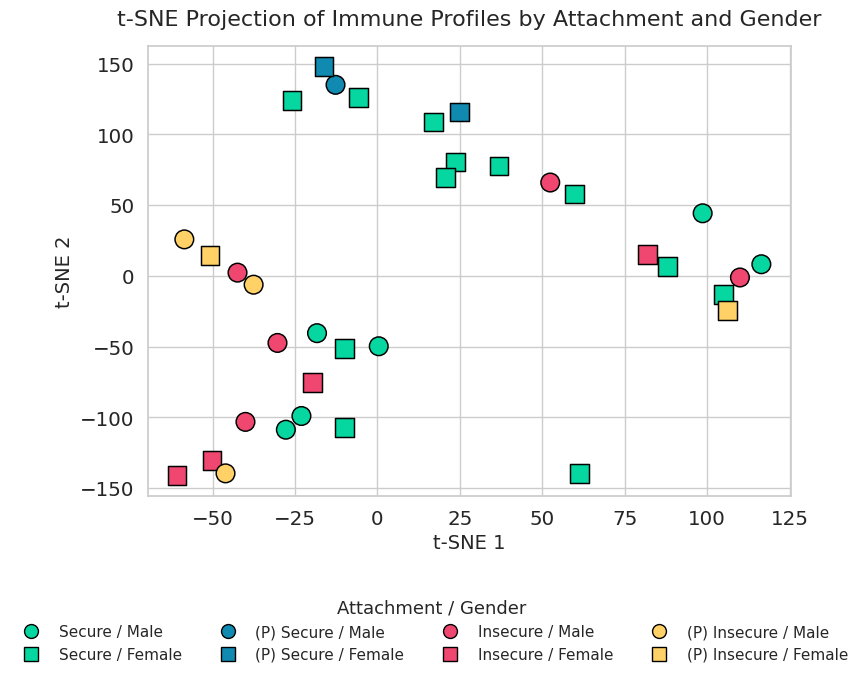

In [449]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sns.set(style="whitegrid", font_scale=1.3)

fig, ax = plt.subplots(figsize=(8, 6))

palette = {
    "Insecure": "#EF476F",
    "(P) Insecure": "#FFD166",
    "Secure": "#06D6A0",
    "(P) Secure": "#118AB2"
}
markers = {"Male": "o", "Female": "s"}

sns.scatterplot(
    ax=ax,
    data=tsne_data_transformed,
    x="t-SNE1",
    y="t-SNE2",
    hue="Attachment",
    style="Gender",
    palette=palette,
    markers=markers,
    s=180,
    edgecolor="black"
)

ax.set_title("t-SNE Projection of Immune Profiles by Attachment and Gender", fontsize=16, pad=15)
ax.set_xlabel("t-SNE 1", fontsize=14)
ax.set_ylabel("t-SNE 2", fontsize=14)

ax.get_legend().remove()

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Secure / Male',
           markerfacecolor=palette["Secure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='Secure / Female',
           markerfacecolor=palette["Secure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='(P) Secure / Male',
           markerfacecolor=palette["(P) Secure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='(P) Secure / Female',
           markerfacecolor=palette["(P) Secure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Insecure / Male',
           markerfacecolor=palette["Insecure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='Insecure / Female',
           markerfacecolor=palette["Insecure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='(P) Insecure / Male',
           markerfacecolor=palette["(P) Insecure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='(P) Insecure / Female',
           markerfacecolor=palette["(P) Insecure"], markeredgecolor='black', markersize=10),
]

fig.legend(
    handles=legend_elements,
    title="Attachment / Gender",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    frameon=False,
    fontsize=11,
    title_fontsize=13
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()



- Prepare data to export

In [450]:
tsne_data_transformed.columns

Index(['t-SNE1', 't-SNE2', 'Gender', 'sIgA_Average_Morning',
       'sIgA_Average_Afternoon', 'sIgA_Average_Difference', 'Attachment',
       'ID'],
      dtype='object')

In [451]:
raw_data = pd.read_csv("../processed_data/1_processed_data_IgA.csv")
raw_data.head(5)

,ID,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,1,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,4,Male,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure
2,5,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
3,7,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,11,Male,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Unknown


In [454]:
data_to_export = tsne_data_transformed.merge(right=raw_data, on="ID")
data_to_export.columns

Index(['t-SNE1', 't-SNE2', 'Gender_x', 'sIgA_Average_Morning_x',
       'sIgA_Average_Afternoon_x', 'sIgA_Average_Difference_x', 'Attachment_x',
       'ID', 'Gender_y', 'sIgA_Average_Morning_y', 'sIgA_Average_Afternoon_y',
       'sIgA_Average_Difference_y', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment_y'],
      dtype='object')

In [455]:
data_to_export = data_to_export[['Gender_x', 'sIgA_Average_Morning_x',
       'sIgA_Average_Afternoon_x', 'sIgA_Average_Difference_x', 'Attachment_x',
       'ID', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment_y']]
data_to_export.columns = ['Gender', 'sIgA_Average_Morning',
       'sIgA_Average_Afternoon', 'sIgA_Average_Difference', 'Attachment_pred',
       'ID', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment_real']
data_to_export.head(5)

,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,Attachment_pred,ID,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment_real
0,Male,21.765240,28.368055,6.602815,Insecure,1,3.077296,3.338237,0.260941,Insecure
1,Male,28.473065,50.881961,22.408896,Secure,4,3.348951,3.687484,0.338533,Secure
2,Female,161.424693,46.867951,-114.556742,Secure,5,5.084039,3.847334,-1.236705,Secure
3,Female,24.173487,35.942378,14.343241,Insecure,7,3.179553,3.581917,0.402364,Insecure
4,Female,29.554870,45.078186,15.523316,Secure,12,3.368950,3.587869,0.218919,Secure


In [456]:
data_to_export['Attachment_pred'].value_counts()

Attachment_pred
Secure          18
Insecure         9
(P) Insecure     5
(P) Secure       3
Name: count, dtype: int64

In [457]:
data_to_export['Attachment_pred'] = data_to_export['Attachment_pred'].replace({
    '(P) Insecure' : 'Insecure',
    '(P) Secure'  : 'Secure'
})

data_to_export['Attachment_pred'].value_counts()

Attachment_pred
Secure      21
Insecure    14
Name: count, dtype: int64

In [458]:
data_to_export.columns

Index(['Gender', 'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'Attachment_pred', 'ID',
       'sIgA_Average_Morning_log', 'sIgA_Average_Afternoon_log',
       'sIgA_Average_Difference_log', 'Attachment_real'],
      dtype='object')

In [459]:
data_to_export = data_to_export[['ID', 'Gender', 'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'sIgA_Average_Morning_log', 'sIgA_Average_Afternoon_log',
       'sIgA_Average_Difference_log', 'Attachment_pred']]

data_to_export.columns = ['ID', 'Gender', 'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'sIgA_Average_Morning_log', 'sIgA_Average_Afternoon_log',
       'sIgA_Average_Difference_log', 'Attachment']
data_to_export.to_csv("../processed_data/2_processed_data_with_attachment_predicted.csv", index=False)